Connected to tracking-barbell-exercises (Python 3.8.15)

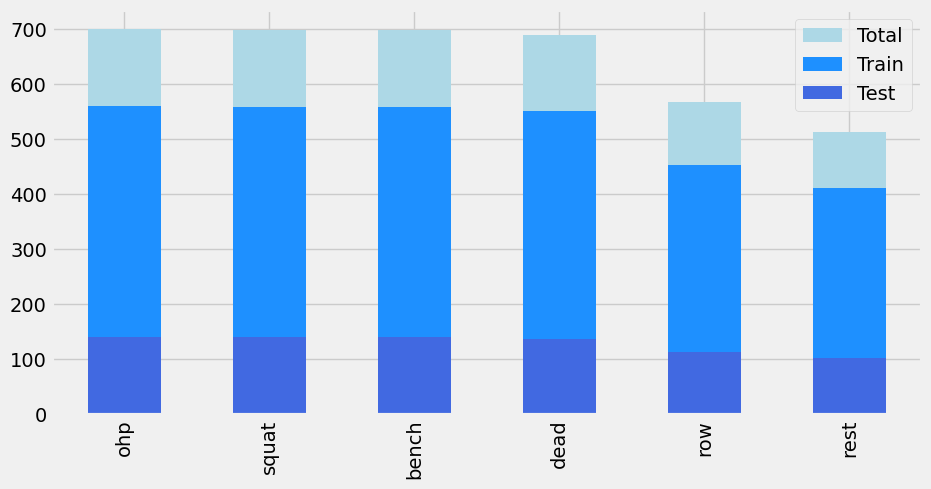

Basic features 6
Square features 2
PCA features 4
Time features 16
Frequency features 88
Cluster features 1


In [1]:
import numpy as np
import pandas as pd
import joblib
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from LearningAlgorithms import ClassificationAlgorithms


# Plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2
df = pd.read_pickle("../data/interim/03_data_features.pkl")

# --------------------------------------------------------------
# Create a training and test set
# --------------------------------------------------------------
df_train = df.drop(["participant", "category", "set"], axis=1)
X = df_train.drop("label", axis=1)
y = df_train["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

fig, ax = plt.subplots(figsize=(10, 5))
df_train["label"].value_counts().plot(
    kind="bar", ax=ax, color="lightblue", label="Total"
)

y_train.value_counts().plot(kind="bar", ax=ax, color="dodgerblue", label="Train")
y_test.value_counts().plot(kind="bar", ax=ax, color="royalblue", label="Test")
plt.legend()
plt.show()

# --------------------------------------------------------------
# Split feature subsets
# --------------------------------------------------------------
basic_features = ["acc_x", "acc_y", "acc_y", "gyr_x", "gyr_y", "gyr_z"]
square_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3", "pca_4"]
time_features = [t for t in df_train.columns if "_temp_" in t]
frequency_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]
cluster_features = ["cluster"]
print("Basic features", len(basic_features))
print("Square features", len(square_features))
print("PCA features", len(pca_features))
print("Time features", len(time_features))
print("Frequency features", len(frequency_features))
print("Cluster features", len(cluster_features))
feature_set_1 = basic_features
feature_set_2 = basic_features + square_features + pca_features
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + frequency_features + cluster_features))

In [2]:
# --------------------------------------------------------------
# Perform forward feature selection using simple decision tree
# --------------------------------------------------------------
learner = ClassificationAlgorithms()
max_features = 5
# Since we have some kind of stochastic process here, run 3 iterations

selected_features = []
ordered_scores = []
for i in range(0, 3):
    print(f"Iteration {i}")
    sel_features, ord_scores = learner.forward_selection(
        max_features=max_features, X_train=X_train, y_train=y_train
    )
    selected_features.append(sel_features)
    ordered_scores.append(ord_scores)

Iteration 0
	Number of features: 1/5
	Number of features: 2/5
	Number of features: 3/5
	Number of features: 4/5
	Number of features: 5/5
Iteration 1
	Number of features: 1/5
	Number of features: 2/5
	Number of features: 3/5
	Number of features: 4/5
	Number of features: 5/5
Iteration 2
	Number of features: 1/5
	Number of features: 2/5
	Number of features: 3/5
	Number of features: 4/5
	Number of features: 5/5


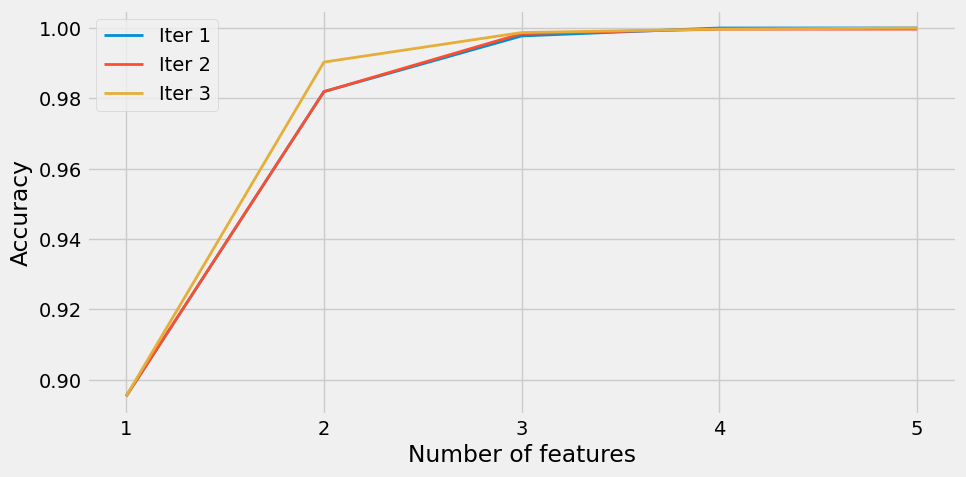

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.arange(1, max_features + 1, 1), ordered_scores[0], label="Iter 1")
ax.plot(np.arange(1, max_features + 1, 1), ordered_scores[1], label="Iter 2")
ax.plot(np.arange(1, max_features + 1, 1), ordered_scores[2], label="Iter 3")
ax.set_xticks(np.arange(1, max_features + 1, 1))
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [4]:
selected_features

[['acc_y_temp_mean_ws_5',
  'duration',
  'acc_z_freq_0.0_Hz_ws_14',
  'acc_x_freq_0.0_Hz_ws_14',
  'gyr_z'],
 ['acc_y_temp_mean_ws_5',
  'duration',
  'gyr_r_freq_0.0_Hz_ws_14',
  'acc_x_freq_0.0_Hz_ws_14',
  'gyr_z'],
 ['acc_y_temp_mean_ws_5',
  'gyr_r_freq_0.0_Hz_ws_14',
  'acc_y_freq_0.0_Hz_ws_14',
  'duration',
  'gyr_z_temp_std_ws_5']]

In [5]:
# The plot shows that it makes sense to use a set of 3 features.
# Add a 4th feature 'duration' as it's #2 in one of the selected_feature list
handpicked_features = [
    "acc_y_temp_mean_ws_5",
    "gyr_r_freq_0.0_Hz_ws_14",
    "acc_y_freq_0.0_Hz_ws_14",
    "duration",
]

In [6]:
# --------------------------------------------------------------
# Grid search for best hyperparameters and model selection
# --------------------------------------------------------------
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    handpicked_features,
]

feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
    "Selected features",
]

iterations = 1
score_df = pd.DataFrame()

In [7]:
# Train 5 models at the same time performing a grid search
## The code is from Mark Hoogendoorn and Burkhardt Funk,
## Machine Learning for the Quantified Self,Springer, 2017
for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]
    # First run non deterministic classifiers to average their score
    performance_test_nn = 0
    performance_test_rf = 0
    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)
        print("\tTraining random forest,", it)
        (
            rf_best_params,
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)
    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations
    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        knn_best_params,
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)
    print("\tTraining decision tree")
    (
        dt_best_params,
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)
    print("\tTraining naive bayes")
    (
        nb_model,
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)
    performance_test_nb = accuracy_score(y_test, class_test_y)
    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


In [9]:
score_df.sort_values(by="accuracy", ascending=False)

,model,feature_set,accuracy
1,RF,Feature Set 4,0.997416
0,NN,Selected features,0.997416
3,DT,Selected features,0.996124
0,NN,Feature Set 4,0.996124
1,RF,Feature Set 3,0.994832
1,RF,Selected features,0.993540
2,KNN,Selected features,0.992248
0,NN,Feature Set 3,0.984496
4,NB,Selected features,0.983204
4,NB,Feature Set 4,0.983204


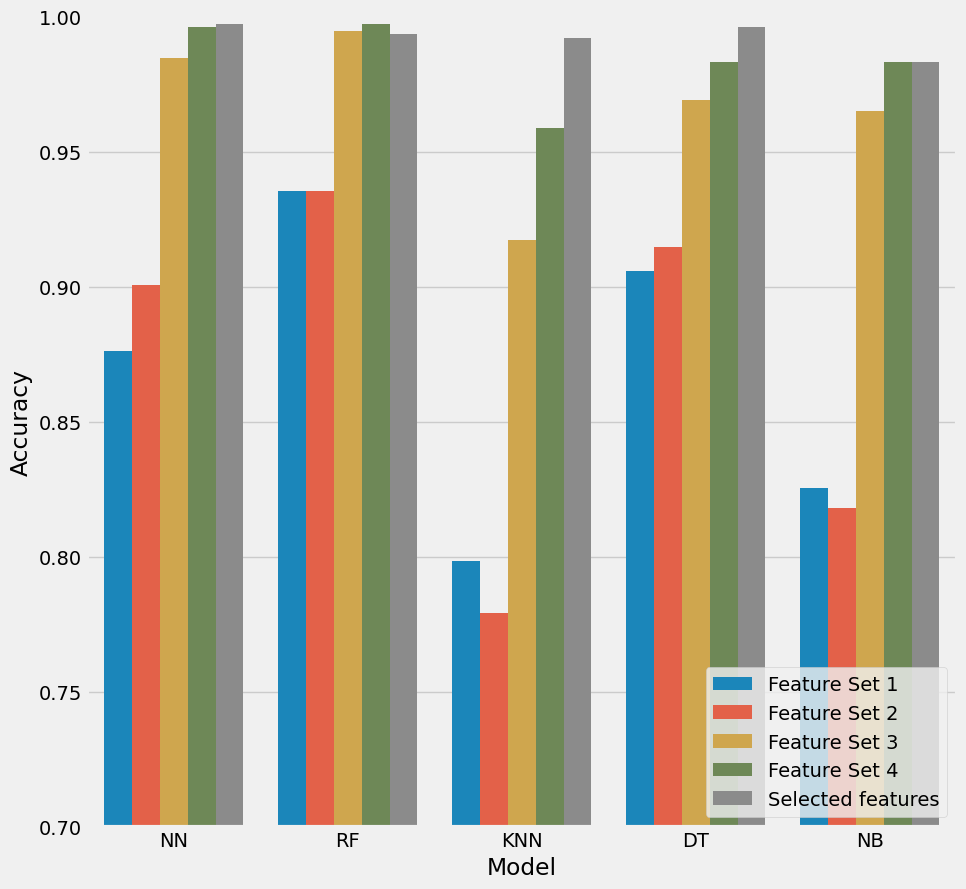

In [10]:
# --------------------------------------------------------------
# Create a grouped bar plot to compare the results
# --------------------------------------------------------------
plt.figure(figsize=(10, 10))
sns.barplot(x="model", y="accuracy", hue="feature_set", data=score_df)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.show()

In [11]:
# --------------------------------------------------------------
# Select best model and evaluate results
# --------------------------------------------------------------
# The RF showed the best result, but DT showed almost the same result on
# a much smoller set of features, so I choose DT as the main algorithm
criterion = dt_best_params["criterion"]
min_samples_leaf = dt_best_params["min_samples_leaf"]
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.decision_tree(
    X_train[handpicked_features],
    y_train,
    X_test[handpicked_features],
    criterion=criterion,
    min_samples_leaf=min_samples_leaf,
    gridsearch=False,
)

accuracy = accuracy_score(y_test, class_test_y)
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

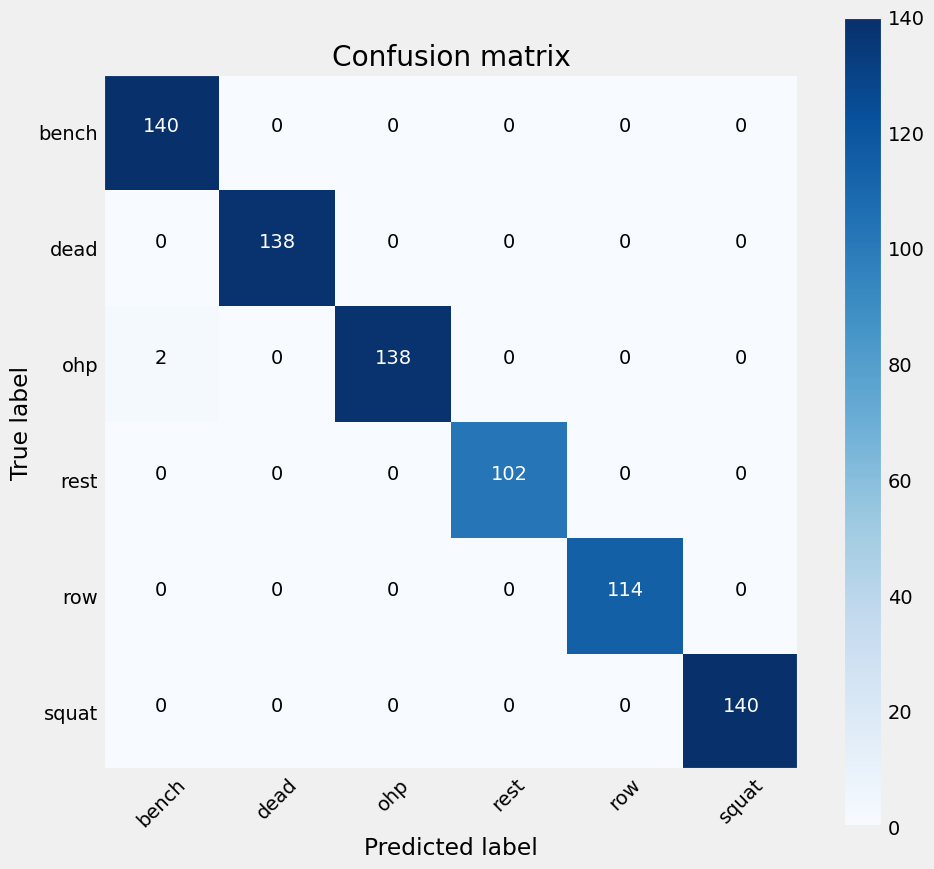

In [12]:
# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()